In [62]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import copy

In [173]:
def map_path(game, path):

    l = [x[:] for x in game.lake]
    for x, y, a in path:
        l[x][y] = FrozenLake.actions[a]
    
    return '\n'.join(('|' + ''.join(row) + '|') for row in l).replace('F', ' ').replace('H', 'X')

In [174]:
class FrozenLake(object):
    '''
    A frozen lake game! It's a lake that's frozen, but it's got some holes that you should
    avoid. Or, maybe it's a desert with patches of quicksand. Either way, you have to get from 
    S(tart) to G(oal) without dying. it's 2D, so for any state, there are only four available 
    actions: left, right, up and down. But it's a windy, slippery landscape, so choosing to go 
    left only actually takes you left with a certain probability. The game is so easy that you
    can just look at a board and see the optimal strategy.
    '''

    actions = ['v', '^', '>', '<']
    
    def __init__(self, n=4, nholes=4, seed=501):

        np.random.seed(seed)

        # for now, it's an n x n square lake
        self.n = n 
        self.m = n
        self.start = (0, 0)
        self.goal = (self.n - 1, self.m - 1)
        
        # if you just construct holes randomly, it can potentially lead to unsolvable boards
        # rather deal with the complication of checking for solvability, I will construct
        # boards that are guaranteed to be solvable. however, this limits the number of holes
        # I will let you drill. Basically, I will first carve out a winning path. Then I will
        # randomly place holes at the remaining spots until I have as many holes as requested.
        self.nholes = nholes
        assert nholes <= (self.n - 1) * (self.m - 1)

        # the Q-value function, which maps states and actions to expected future-discounted
        # rewards
        self.Q = 0.01 * np.random.rand(self.n, self.m, len(self.actions))

        # construct lake with holes
        self.lake = None
        self._freeze_lake()
        
     
    def _freeze_lake(self):
     
        # the lake is after all ... frozen
        if self.lake:
            return
        
        # choose first a winning path. we don't put holes here!!
        # This works provided self.goal is dictionary ordered > self.start.
        x, y = self.start
        winning_path = [(x, y)]
        while (x, y) != self.goal:
            
            if x == self.goal[0]:
                y += 1
            elif y == self.goal[1]:
                x += 1
            else:
                right = int( np.random.random() > 0.5 )
                x += right
                y += 1 - right
            
            winning_path.append((x,y))
            
        # make base game with no holes
        self.lake = [['F' for _ in range(self.m)] for _ in range(self.n)]       
        self.lake[self.start[0]][self.start[1]] = 'S'
        self.lake[self.goal[0]][self.goal[1]] = 'G'
        
        # generate holes and add to the board
        candidate_holes = list(set((x,y) for x in range(self.n) for y in range(self.m)) - set(winning_path))
        np.random.shuffle(candidate_holes)
        self.holes = candidate_holes[-self.nholes:]

        for j, k in self.holes:
            self.lake[j][k] = 'H'
    
        return
    
    
    def _move(self, i, j, eps):
        
        # choose action: with probability self.eps, take the direction of 
        # maximal Q value (which at first is actually random) and
        # with probability 1 - self.eps, take a random step         
        if np.random.rand() < eps:
            action = np.argmax(self.Q[i, j, :])
        else:
            action = np.random.randint(0, 4)

        i1, j1 = i, j

        if action == 0:
            i1 = i + 1
        elif action == 1:
            i1 = i - 1
        elif action == 2:
            j1 = j + 1
        else:
            j1 = j - 1
    
        return i1, j1, action
    
    
    def play(self):
        return self.learn(lr=0, gamma=0, eps=0.9)
    

    def learn(self, lr=0.1, gamma=0.7, eps=0.9, rbase = -0.05):
        
        path = []
        i1, j1 = self.start
        
        while 1:
            
            # set start state to end state of last iteration
            i, j = i1, j1

            # find next position
            i1, j1, action = self._move(i, j, eps)
            path.append((i, j, action))
          
            # check for death
            if not 0 <= i1 < self.n or not 0 <= j1 < self.n or (i1, j1) in self.holes:
                self.Q[i, j, action] = -1             
                return path, 'DIE'
            
            # check for win
            if (i1, j1) == self.goal:
                self.Q[i, j, action] = 1
                return path, 'WIN'

            # continue
            self.Q[i, j, action] = (1 - lr) * self.Q[i, j, action] + lr * (rbase + gamma * max(self.Q[i1, j1, :]))

            
    def __repr__(self):
        return '\n'.join(('|' + ''.join(row) + '|') for row in self.lake).replace('F', ' ').replace('H', 'X')


In [206]:
n = 8
holes = 5
game = FrozenLake(n=n, nholes=16, seed=1000)
print game

|SXX XXXX|
|   X  X |
|        |
|        |
|    XX  |
|    X   |
|     X X|
|X XX   G|


In [207]:
Q = np.array(game.Q)
batch_size = 10000
play_size = 1000
for batch in xrange(20):
    [game.learn(eps=0.9) for n in range(batch_size)]
    print batch, sum(x[1] == 'WIN' for x in [game.play() for n in range(play_size)]), play_size
    
#print Q - game.Q
#print game.Q

0 666 1000
1 605 1000
2 654 1000
3 633 1000
4 644 1000
5 614 1000
6 621 1000
7 578 1000
8 611 1000
9 600 1000
10 569 1000
11 604 1000
12 626 1000
13 595 1000
14 605 1000
15 613 1000
16 582 1000
17 613 1000
18 597 1000
19 589 1000


In [215]:
path, _ = game.play()
path
print map_path(game, path)

|vXX XXXX|
|v  X  X |
|v       |
|v       |
|v   XX  |
|v   X   |
|>>>>vX X|
|X XX>>>G|


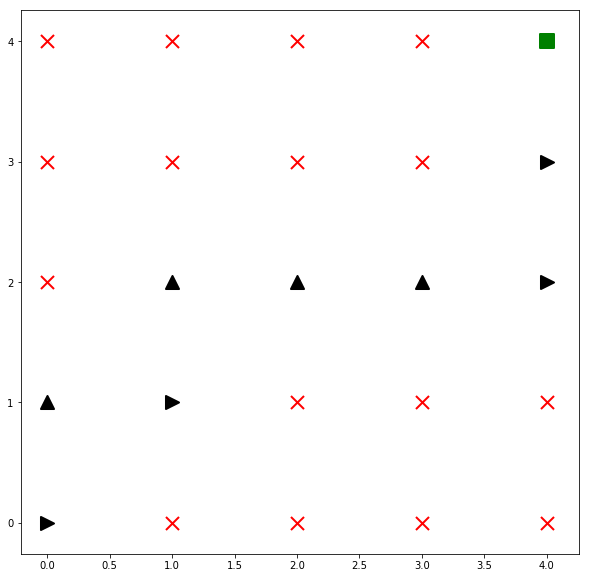

In [123]:
#
# visualize learned strategy
#
actions = ['^', 'v', '>', '<']
moves = game.Q.argmax(axis=2)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
#axes[0,0].pcolor(moves == 0) # down
#axes[0,1].pcolor(moves == 1) # up
#axes[1,0].pcolor(moves == 2) # left
#axes[1,1].pcolor(moves == 3) # right

for x in range(game.n):
    for y in range(game.m):
        if (x,y) in game.holes:
            marker = 'x'
            c = 'r'
        elif (x,y) == game.goal:
            marker = ','
            c = 'g'
        else:
            marker = actions[moves[x,y]]
            c = 'k'

        ax.scatter([x], [y], lw=2, c=c, marker=marker, s=170)        


In [92]:
game.Q

array([[[-1.00000000e+00, -1.00000000e+00, -7.05866500e-02,
         -1.00000000e+00],
        [-2.94095000e-02, -1.00000000e+00, -1.00000000e+00,
         -9.94106550e-02],
        [ 2.33132197e-03,  8.41740724e-03,  2.07082344e-03,
          7.42469534e-03],
        [ 3.92154128e-03,  1.82256520e-03,  7.43539415e-03,
          6.95820810e-04],
        [ 8.85337204e-03,  9.52644399e-03,  9.31143435e-03,
          4.15430953e-03]],

       [[ 2.89816594e-04,  9.82027485e-03,  3.39637684e-03,
          7.06687194e-03],
        [-1.00000000e+00, -7.05866500e-02,  2.94150000e-02,
         -1.00000000e+00],
        [ 1.13450000e-01, -1.00000000e+00, -1.00000000e+00,
         -2.94095000e-02],
        [ 1.04217006e-04,  7.45567361e-04,  2.44629210e-03,
          1.33304752e-03],
        [ 6.97925100e-03,  3.98204884e-03,  8.83122191e-03,
          1.81007510e-03]],

       [[ 4.32499172e-03,  1.81432028e-04,  6.91437862e-03,
          4.69690652e-03],
        [ 1.28222190e-03,  8.91337051e-